### 1. Setup and Imports

In [3]:
# Import necessary libraries
import os
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


### 2. Feature Extraction Function

In [4]:
# Function to extract features from audio files
def extract_features(audio_file):
    try:
        y, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=42)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma_features = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        features = np.hstack([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_contrast, axis=1), np.std(spectral_contrast, axis=1),
            np.mean(chroma_features, axis=1), np.std(chroma_features, axis=1),
            np.mean(rms), np.std(rms),
            np.mean(spectral_rolloff), np.std(spectral_rolloff),
            np.mean(mel_spectrogram, axis=1), np.std(mel_spectrogram, axis=1)
        ])
        return features
    except Exception as e:
        logging.error(f"Error extracting features from {audio_file}: {e}")
        return None


### 3. Data Preprocessing Function

In [5]:
# Function to preprocess data
def preprocess_data(base_dirs, is_test=False):
    all_features = []
    labels = []

    for base_dir in base_dirs:
        bird_names = os.listdir(base_dir)
        
        for bird_name in bird_names:
            bird_dir = os.path.join(base_dir, bird_name)
            for f in os.listdir(bird_dir):
                features = extract_features(os.path.join(bird_dir, f))
                if features is not None:
                    all_features.append(features)
                    if is_test:
                        labels.append(bird_name.replace('_test', ''))
                    else:
                        labels.append(bird_name)
        
    
    # Combine features and labels
    X = np.array(all_features)
    y = np.array(labels)
    
    return X, y


# 4. Load and Preprocess Data

In [6]:
# Base directories containing audio files for each class
base_dirs = ['data']

# Preprocess data
X, y = preprocess_data(base_dirs)



# Shuffle the data
shuffled_indices = np.random.RandomState(42).permutation(len(y))
X = X[shuffled_indices]
y = y[shuffled_indices]

# Fit the scaler on all collected features
scaler = StandardScaler()
scaler.fit(X)

# Normalize features using the fitted scaler
X_scaled = scaler.transform(X)

# Dimensionality reduction (optional)
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.01, random_state=42)


/home/sushovan/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=154
  warnings.warn(


### 5. Define and Train Classifiers

Initial Split Test Accuracies:
Random Forest: 1.0
Gradient Boosting: 1.0
k-NN: 1.0
Decision Tree: 0.90625
SVM: 1.0
MLP: 1.0
Naive Bayes: 0.71875
Logistic Regression: 1.0


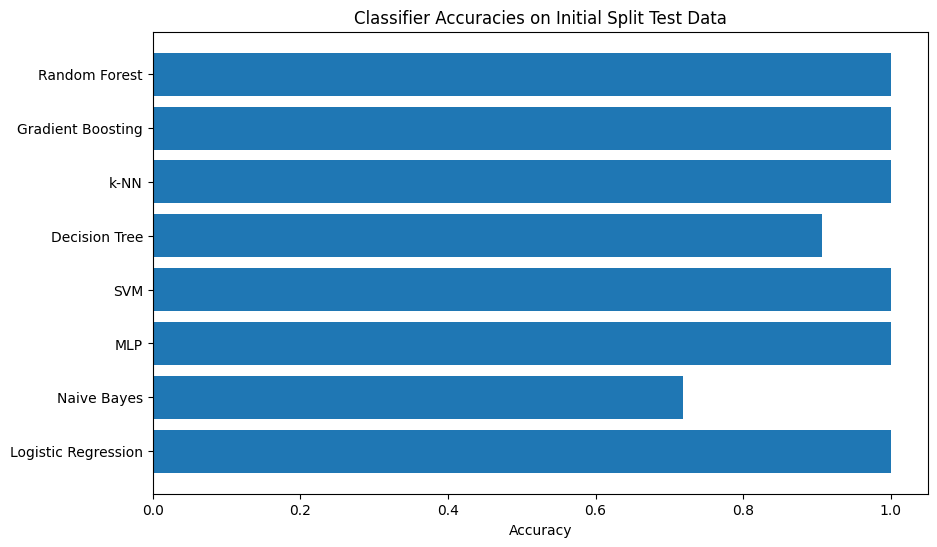

In [7]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'k-NN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Train and test each classifier
accuracies = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred_test)

# Print initial split test accuracies
print("Initial Split Test Accuracies:")
for name, accuracy in accuracies.items():
    print(f"{name}: {accuracy}")

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.barh(range(len(accuracies)), list(accuracies.values()), align='center')
plt.yticks(range(len(accuracies)), list(accuracies.keys()))
plt.xlabel('Accuracy')
plt.title('Classifier Accuracies on Initial Split Test Data')
plt.gca().invert_yaxis()
plt.show()


<Figure size 2000x2000 with 0 Axes>

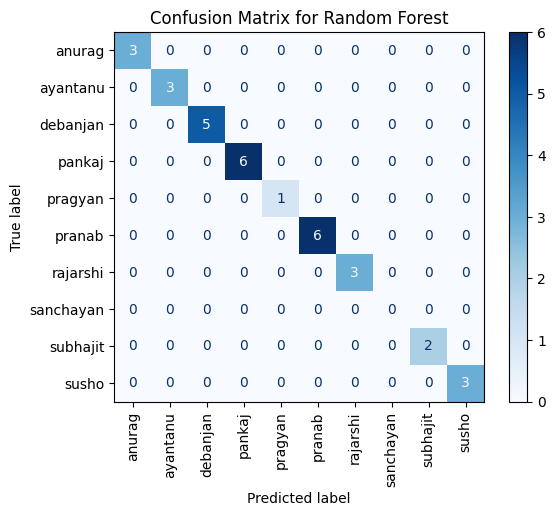

In [8]:

# Evaluate classifiers on the new test data
test_accuracies = {}
best_classifier = None
best_accuracy = 0
best_classifier_name = ""

for name, clf in classifiers.items():
    y_pred_test = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    test_accuracies[name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = clf
        best_classifier_name = name



# Generate and display confusion matrix for the best classifier
y_pred_best = best_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=best_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_classifier.classes_)

plt.figure(figsize=(20,20))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f"Confusion Matrix for {best_classifier_name}")
plt.show()

In [9]:
# Function to predict the speaker from a single WAV file
def predict_speaker(audio_file_path):
    try:
        # Step 1: Extract features from the audio file
        features = extract_features(audio_file_path)
        if features is None:
            logging.error("No features could be extracted from the audio file.")
            return None
        
        scaler = StandardScaler()
        scaler.fit(X)
        # Step 2: Preprocess features
        features_scaled = scaler.transform([features])  # Normalize using the fitted scaler
        features_pca = pca.transform(features_scaled)   # Apply PCA transformation using the fitted PCA model
        
        # Step 3: Predict the speaker using the best classifier
        predicted_label = best_classifier.predict(features_pca)[0]
        
        return predicted_label
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        return None

In [10]:
# Example usage:
audio_file_path = "test1.wav"
predicted_speaker = predict_speaker(audio_file_path)

if predicted_speaker:
    print(f"The predicted speaker is: {predicted_speaker}")
else:
    print("Failed to predict the speaker.")

The predicted speaker is: susho


In [11]:
# Example usage:
audio_file_path = "test2.wav"
predicted_speaker = predict_speaker(audio_file_path)

if predicted_speaker:
    print(f"The predicted speaker is: {predicted_speaker}")
else:
    print("Failed to predict the speaker.")

The predicted speaker is: susho


In [12]:
# Example usage:
audio_file_path = "test3.wav"
predicted_speaker = predict_speaker(audio_file_path)

if predicted_speaker:
    print(f"The predicted speaker is: {predicted_speaker}")
else:
    print("Failed to predict the speaker.")

The predicted speaker is: susho


In [13]:
import joblib

# Assuming `best_classifier` is your trained model
model_path = "best_classifier_model.pkl"

# Save the trained model
joblib.dump(best_classifier, model_path)
print(f"Model saved to {model_path}")



# Paths to save the scaler and PCA
scaler_path = "scaler.pkl"
pca_path = "pca.pkl"

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the PCA
joblib.dump(pca, pca_path)
print(f"PCA saved to {pca_path}")



Model saved to best_classifier_model.pkl
Scaler saved to scaler.pkl
PCA saved to pca.pkl


In [14]:
np.shape(X_train)

(3079, 388)

### 6. Evaluate on New Test Data

/home/sushovan/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=154
  warnings.warn(



Final Test Accuracies:
Random Forest: 1.0
Gradient Boosting: 1.0
k-NN: 0.9848923175827708
Decision Tree: 0.9990356798457087
SVM: 1.0
MLP: 1.0
Naive Bayes: 0.6698810671809707
Logistic Regression: 1.0


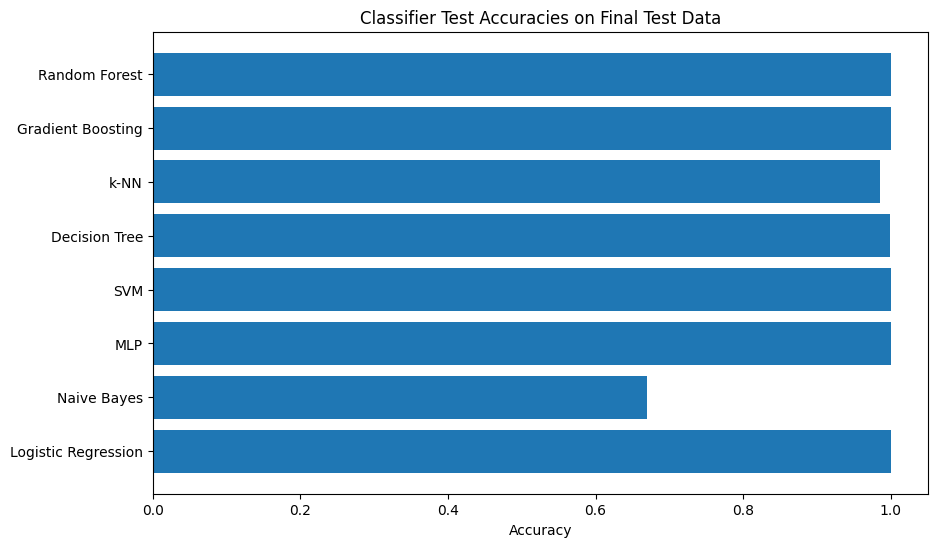

In [15]:
# Preprocess test data
test_base_dirs = ['data']
X_test_new, y_test_new = preprocess_data(test_base_dirs, is_test=True)

# Normalize test features using the fitted scaler
X_test_new_scaled = scaler.transform(X_test_new)

# Apply PCA transformation using the fitted PCA model
X_test_new_pca = pca.transform(X_test_new_scaled)

# Evaluate classifiers on the new test data
test_accuracies = {}
best_classifier = None
best_accuracy = 0
best_classifier_name = ""

for name, clf in classifiers.items():
    y_pred_test_new = clf.predict(X_test_new_pca)
    accuracy = accuracy_score(y_test_new, y_pred_test_new)
    test_accuracies[name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = clf
        best_classifier_name = name

# Print final test accuracies
print("\nFinal Test Accuracies:")
for name, accuracy in test_accuracies.items():
    print(f"{name}: {accuracy}")

# Plot test accuracies
plt.figure(figsize=(10, 6))
plt.barh(range(len(test_accuracies)), list(test_accuracies.values()), align='center')
plt.yticks(range(len(test_accuracies)), list(test_accuracies.keys()))
plt.xlabel('Accuracy')
plt.title('Classifier Test Accuracies on Final Test Data')
plt.gca().invert_yaxis()
plt.show()


### 7. Confusion Matrix for Best Classifier

<Figure size 2000x2000 with 0 Axes>

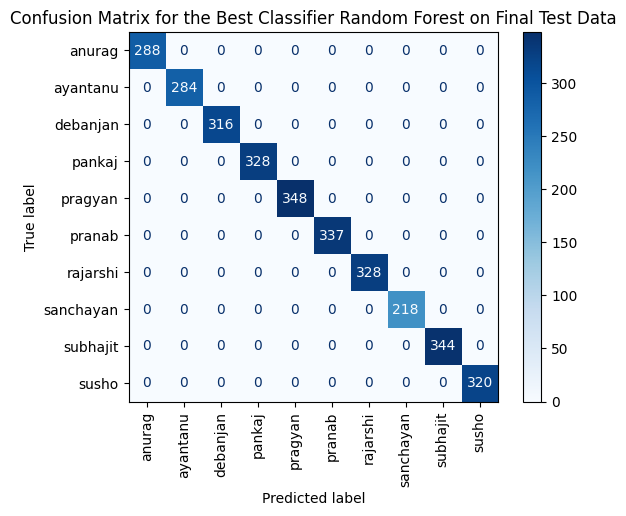

In [16]:
# Generate and display confusion matrix for the best classifier
y_pred_best = best_classifier.predict(X_test_new_pca)
cm = confusion_matrix(y_test_new, y_pred_best, labels=best_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_classifier.classes_)

plt.figure(figsize=(20,20))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.title(f"Confusion Matrix for the Best Classifier {best_classifier_name} on Final Test Data")
plt.show()